# Quantum Information and Computing Project

## Assignment


The goal of this assignment is to simulate and analyze wave propagation in 1D under various physical models and potentials using the `FEniCS` finite element library.

In [1]:
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

### Part I - Classical Wave Equation

Simulate the classical 1D wave equation:

$$\frac{\partial^2u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}$$

where $u(x,t)$ is the wave field and $c$ is the wave speed.

1. Implement the wave equation in `FEniCS`.
2. Use an initial gaussian pulse centered in the domain with zero initial velocity.
3. Compare the propagation with and without a spatially varying wave speed $c(x)$ and check the results with analytical solutions where available.
4. (Optional) Simulate wave propagation across an interface where has a discontinuity. Define $c(x)=c_1$ for $x<x_0$ and $c(x)=c_2$ for $x>x_0$. Place the initial pulse at $x<x_0$ and observe reflection and transmission. Compare transmitted/reflected waveforms to analytical predictions (e.g., acoustic Fresnel coefficients).

In [2]:
# Gaussian function
def gaussian(x, x0, sigma):
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-0.5 * ((x - x0) / sigma)**2)

# Constant piecewise function
def c_piecewise(x, c1, c2, L):
    return np.where(x < L/2, c1, c2)

In [214]:
def classical_wave_function(L, nx, T, dt, c, f, bc = "Dirichlet", n_plots = 6):
    
    # Physics domain and function space
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
    V      = fem.functionspace(domain, ("Lagrange", 1))
    
    # Boundary conditions
    bc_list = []
    
    if bc == "Neumann":
        
        bc_list = []
    
    elif bc == "Dirichlet":
        
        u_bc            = fem.Function(V)
        u_bc.x.array[:] = 0.0
        
        facets = mesh.locate_entities_boundary(
            domain,
            dim    = 0,
            marker = lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
        )
        
        dofs    = fem.locate_dofs_topological(V, entity_dim = 0, entities = facets)
        bc_list = [fem.dirichletbc(u_bc, dofs)]
        
    # Function at different time steps
    u_past    = fem.Function(V)   # u_{i-1}
    u_present = fem.Function(V)   # u_{i}
    u_future  = fem.Function(V)   # u_{i+1}
    
    # Inizialization
    x_coords             = V.tabulate_dof_coordinates()[:, 0]
    u_past.x.array[:]    = f(x_coords)
    u_present.x.array[:] = u_past.x.array   # Inizial velocity v = 0
    
    # Velocity
    
    # Constant velocity
    if np.isscalar(c):
        
        c2   = fem.Constant(domain, PETSc.ScalarType(c**2))
        wall = False
        
        v_max = c
       
    # Generical function
    else:
        
        c_fun = fem.Function(V)
        wall  = True
        
        if callable(c):
            c_fun.interpolate(lambda x: c(x[0])**2)
        else:
            c_fun.x.array[:] = np.asarray(c(x_coords))**2
            
        c2 = c_fun
        
        v_max = np.sqrt(np.max([c_fun.x.array[0], c_fun.x.array[-1]]))
        
    # CFL check
    CFL = v_max*dt / (L/nx)
    print(f"CFL = {CFL:.3f}\n")
    
    # Functions in weak form
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    # Constant matrix A
    a_form = (u*v / dt**2) * ufl.dx + c2 * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
    A      = fem_petsc.assemble_matrix(fem.form(a_form), bcs = bc_list)
    A.assemble()
    
    # Solving through LU decomposition
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType("preonly")
    solver.getPC().setType("lu")
    
    # Time values
    nt      = int(T / dt) + 1
    t_vals  = np.linspace(0.0, T, nt)
    t_plots = np.linspace(0.0, T, n_plots)
    
    # Setup to transmitting and reflecting coefficients evaluation
    if wall == True:
        i_mid   = np.argmin(np.abs(x_coords - L/2))
        i_left  = np.argmin(np.abs(x_coords - L/4))       
        i_right = np.argmin(np.abs(x_coords - 3*L/4))
        
        t_cross       = None
        t_transmitted = None
        t_reflected   = None
        
        initial_amplitude     = None
        transmitted_amplitude = None
        reflected_amplitude   = None
        
        threshold = 0.05
    
    else:
        t_cross = None
        
    # Setup for energies storing
    energies = []
    
    # Plot figure
    plt.figure(figsize = (10, 6))
    
    # Temporal loop
    for t_current in t_vals:

        if np.any(np.isclose(t_current, t_plots, atol = dt / 2)):
            
            # Plots
            plt.plot(x_coords, u_present.x.array, label = f"t = {t_current:.2f}")
            
            # Energies
            u_t            = fem.Function(V)
            u_t.x.array[:] = (u_present.x.array - u_past.x.array) / dt
            
            energy_form = 0.5 * ((u_t**2) / c2 + ufl.inner(ufl.grad(u_present), ufl.grad(u_present))) * ufl.dx
            E           = fem.assemble_scalar(fem.form(energy_form))
            
            if t_current == 0.0:
                E0 = E
                
            print(f"Energy at time {t_current:.3f}: {E/E0:.3f}")
            energies.append(E/E0)

        # Skip last temporal step
        if np.isclose(t_current, T):
            break

        # Right hand side
        L_form = (2.0 * u_present * v / dt**2 - u_past * v / dt**2) * ufl.dx
        b      = fem_petsc.assemble_vector(fem.form(L_form))
        fem_petsc.apply_lifting(b, [fem.form(a_form)], bcs = [bc_list])
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        fem_petsc.set_bc(b, bc_list)

        # Solution
        solver.solve(b, u_future.x.petsc_vec)
        u_future.x.scatter_forward()

        # Update for new time step
        u_past.x.array[:]    = u_present.x.array
        u_present.x.array[:] = u_future.x.array
        
        # Evaluation of transmissing and reflecting coefficients
        if wall == True:
            
            umax = np.max(np.abs(u_present.x.array))
            
            if t_cross is None and np.abs(u_present.x.array[i_mid]) > threshold * umax:
                t_cross           = t_current
                initial_amplitude = umax
                
            if t_cross is not None and transmitted_amplitude is None:
                u_mid   = u_present.x.array[i_mid]
                u_right = u_present.x.array[i_right]
                
                if np.isclose(u_mid, u_right, rtol = 1e-2):
                    transmitted_amplitude = np.max(np.abs(u_present.x.array[i_mid:i_right+1]))
                    t_transmitted         = t_current
            
            if t_cross is not None and reflected_amplitude is None:
                u_mid  = u_present.x.array[i_mid]
                u_left = u_present.x.array[i_left]
                
                if np.isclose(u_mid, u_left, rtol = 1e-2):
                    reflected_amplitude = np.max(np.abs(u_present.x.array[i_left:i_mid+1]))
                    t_reflected         = t_current
                    
    if t_cross is None:
        wall = False
        if np.isscalar(c) == False:
            print("\nThe time was not enough for the wave to cross the wall")

    # Fresnel coefficients
    if wall == True and initial_amplitude is not None:
        
        print("\nTimes:")
        print(f"   Crossing the wall: t = {t_cross:.3f}")
        
        if transmitted_amplitude is not None:
            print(f"   Transmission:      t = {t_transmitted:.3f}")
        else:
            print("   Not enough time for transmission")
        
        if reflected_amplitude is not None:
            print(f"   Reflection:        t = {t_reflected:.3f}")
        else:
            print("   Not enough time for reflection")
        
        print("\nAmplitudes:")
        print(f"   Initial:     A = {initial_amplitude:.3f}")
        
        if transmitted_amplitude is not None:
            print(f"   Transmitted: A = {transmitted_amplitude:.3f}")
        else:
            print("   Not enough time for transmission")
            
        if reflected_amplitude is not None:
            print(f"   Reflected:   A = {reflected_amplitude:.3f}")
        else:
            print("   Not enough time for reflection")
        
        if transmitted_amplitude is not None:
            t_coeff = transmitted_amplitude / initial_amplitude
        
        if reflected_amplitude is not None:
            r_coeff = reflected_amplitude / initial_amplitude
            if c_fun.x.array[0] < c_fun.x.array[-1]:
                r_coeff *= -1
                
        if transmitted_amplitude is not None and reflected_amplitude is not None:
            print(f"\nEstimated Fresnel coefficients: T = {t_coeff:.3f}, R = {r_coeff:.3f}")
        
        t_coeff_correct = 2*np.sqrt(c_fun.x.array[0]) / (np.sqrt(c_fun.x.array[0]) + np.sqrt(c_fun.x.array[-1]))
        r_coeff_correct = (np.sqrt(c_fun.x.array[0]) - np.sqrt(c_fun.x.array[-1])) / (np.sqrt(c_fun.x.array[0]) + np.sqrt(c_fun.x.array[-1]))
        print(f"Correct Fresnel Coefficients:   T = {t_coeff_correct:.3f}, R = {r_coeff_correct:.3f}\n")
        
        plt.axvline(L/2, color = "k", linestyle = "--", alpha = 0.5, label = "Interface")
        
    # Final plot options
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title(f"FEM reconstruction of the wave function evolution with {bc} boundary conditions")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [23]:
def classica_wave_function_analytical(L, nx, T, c, f, N_modes = 50, bc = "Dirichlet", n_plots = 6):
    
    # Values
    x               = np.linspace(0, L, nx)
    function_values = f(x)
    
    # Coefficients of expansion
    
    if bc == "Dirichlet":

        A = np.zeros(N_modes)
        for n in range(1, N_modes + 1):
            A[n-1] = 2/L * np.trapezoid(function_values * np.sin(n * np.pi * x / L), x)

    elif bc == "Neumann":
        
        A = np.zeros(N_modes + 1)
        A[0] = 1/L * np.trapezoid(function_values, x) 
        for n in range(1, N_modes + 1):
            A[n] = 2/L * np.trapezoid(function_values * np.cos(n * np.pi * x / L), x)
       
    # Times of plot 
    t_plots = np.linspace(0.0, T, n_plots)
       
    # Plot figure 
    plt.figure(figsize = (15, 6))
    
    # Time function evolution
    for t in t_plots:
        
        u = np.zeros_like(x)
        
        if bc == "Dirichlet":
            for n in range(1, N_modes + 1):
                omega_n = n * np.pi * c / L
                u += A[n-1] * np.cos(omega_n * t) * np.sin(n * np.pi * x / L)

        elif bc == "Neumann":
            u += A[0]
            for n in range(1, N_modes + 1):
                omega_n = n * np.pi * c / L
                u += A[n] * np.cos(omega_n * t) * np.cos(n * np.pi * x / L)
            
        plt.plot(x, u, label = f't = {t:.2f}')
     
    # Final plot options   
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title(f"Analytical wave function evolution with {bc} boundary conditions")
    plt.legend()
    plt.grid(True, alpha = 0.3)
    
    plt.show()

In [26]:
L     = 5.0
nx    = 5000
T     = 2.5
dt    = 0.00005
c1    = 1.0
c2    = 3.0
c_fun = partial(c_piecewise, c1 = c1, c2 = c2, L = L)
bc    = "Neumann"

CFL = 0.150

Energy at time 0.000: 1.000
Energy at time 0.500: 0.985
Energy at time 1.000: 0.971
Energy at time 1.500: 0.638
Energy at time 2.000: 0.629
Energy at time 2.500: 0.620
Energy at time 2.500: 0.620

Times:
   Crossing the wall: t = 1.141
   Transmission:      t = 1.458
   Reflection:        t = 1.559

Amplitudes:
   Initial:     A = 3.945
   Transmitted: A = 1.966
   Reflected:   A = 1.964

Estimated Fresnel coefficients: T = 0.498, R = -0.498
Correct Fresnel Coefficients:   T = 0.500, R = -0.500



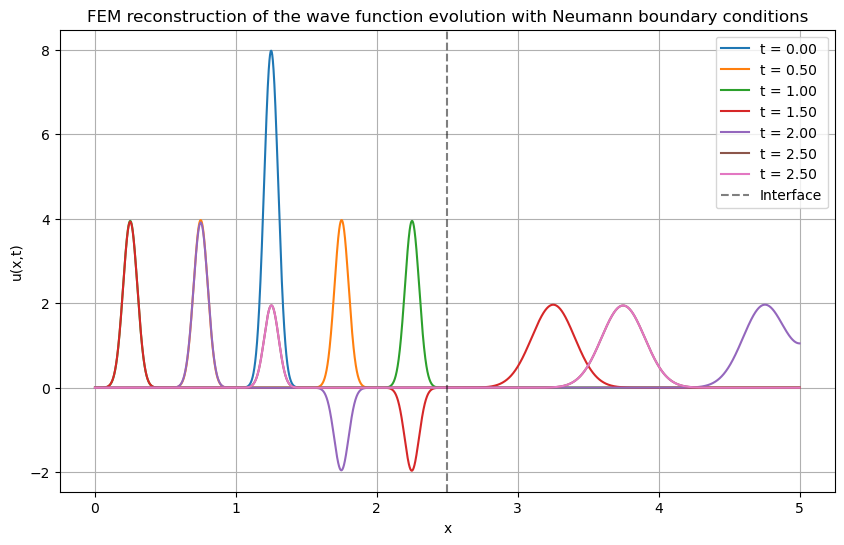

In [242]:
classical_wave_function(
    L       = L,
    nx      = nx,
    T       = T,
    dt      = dt,
    c       = c_fun,
    f       = lambda x: gaussian(x, x0 = L/4, sigma = 0.05),
    bc      = bc,
    n_plots = 6
)

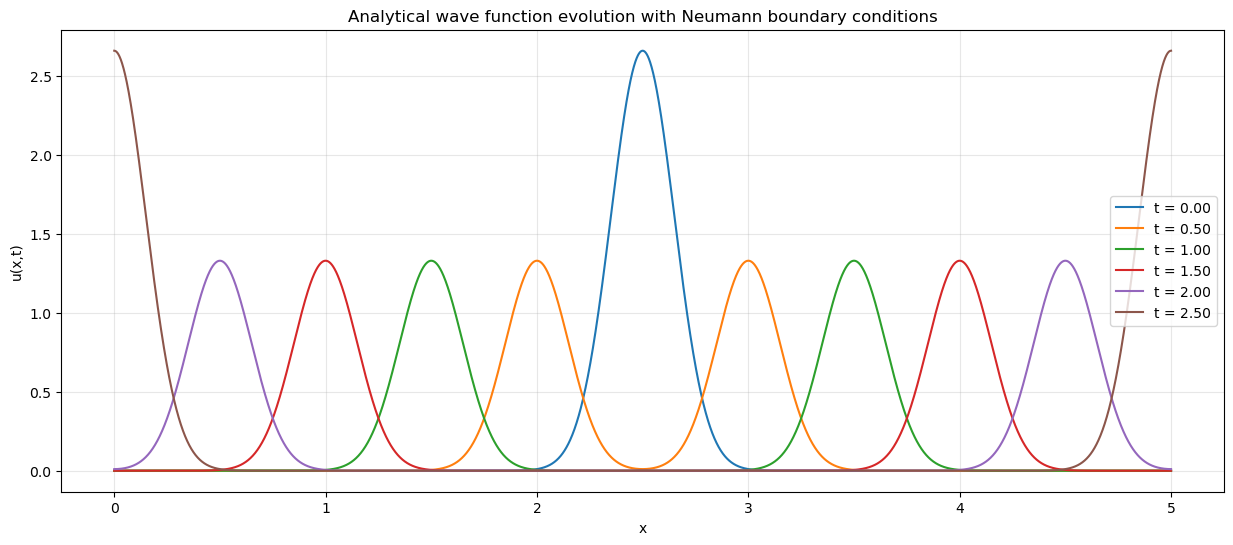

In [27]:
classica_wave_function_analytical(
    L       = L,
    nx      = nx,
    T       = T,
    c       = c1,
    f       = lambda x: gaussian(x, x0 = L/2, sigma = 0.15),
    N_modes = 50,
    bc      = bc,
    n_plots = 6
)

### Part II - Time-Dependent Schrödinger Equation

Simulate the 1D time-dependent Schrödinger equation:

$$i\hbar\frac{\partial\psi}{\partial t}=-\frac{\hbar^2}{2m}\frac{\partial^2\psi}{\partial x^2}+V(x)\psi(x,t)$$

Compute and plot the probability density $|\psi(x,t)|^2$ and the wave packet width $\sigma(t)$ and comment on the dynamical regime (ballistic, diffusive/localized, oscillatory).

Scenarios to simulate:

1. Free particle: $V(x)=0$
- Initial wave packet: gaussian centered at $x_0$
- Observe and quantify ballistic spreading: $\sigma(t)\propto t$

2. Periodic Potential (Kronig-Penney-like): $V(x)=V_0\cos\left(\frac{2\pi}{a}x\right)$
- Observe slower, sub-ballistic spreading and discuss connection with Bloch waves and effective mass

3. Linear Electric Field: $V(x)=Fx$
- Observe Bloch oscillations of a localized wave packet and discuss the absence of net drift in the periodic lattice

In [111]:
def calculate_effective_mass(V0, a, hbar = 1.0, m = 1.0, G_max = 10, k_range = 0.1, n_k = 21):
    
    G_values = np.arange(-G_max, G_max+1) * (2*np.pi/a)
    nG       = len(G_values)
    
    V_matrix = np.zeros((nG, nG), dtype = complex)
    for i, Gi in enumerate(G_values):
        for j, Gj in enumerate(G_values):
            
            delta_G = Gi - Gj

            if np.isclose(delta_G, 2*np.pi/a) or np.isclose(delta_G, -2*np.pi/a):
                V_matrix[i, j] = V0 / 2.0
    
    k_points = np.linspace(-k_range*np.pi/a, k_range*np.pi/a, n_k)
    E_k      = []
    
    for k in k_points:

        H_k = V_matrix.copy()
        for i, Gi in enumerate(G_values):
            H_k[i, i] += (hbar**2 * (k + Gi)**2) / (2*m)
        
        eigenvalues, _ = eigh(H_k)
        E_k.append(eigenvalues[0]) 
    
    E_k = np.array(E_k)
    
    coeffs  = np.polyfit(k_points, E_k, 2)
    d2E_dk2 = 2*coeffs[0]
    m_eff   = hbar**2 / d2E_dk2
    E0      = coeffs[2] 
    
    return m_eff, E0, k_points, E_k

In [202]:
def schrodinger_equation_solution(L, nx, x0, sigma, k0, T, dt, hbar = 1.0, m = 1.0, bc = "Dirichlet", potential_type = "Free-particle", V0 = 1.0, a = 1.0, F = 1.0, n_plots = 6):
    
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [-L/2, L/2]) 
    W      = fem.functionspace(domain, ("Lagrange", 1))
    
    if bc == "Dirichlet":
        
        u_bc            = fem.Function(W)
        u_bc.x.array[:] = 0.0
        
        facets = mesh.locate_entities_boundary(
            domain,
            dim    = 0,
            marker = lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
        )
        
        dofs    = fem.locate_dofs_topological(W, entity_dim = 0, entities = facets)
        bc_list = [fem.dirichletbc(u_bc, dofs)]
        
    elif bc == "Neumann":
        
        bc_list = []
        
    elif bc == "Absorbing":
        
        bc_list = []
        
    u_present = fem.Function(W)
    v_present = fem.Function(W)
    
    x_coords             = W.tabulate_dof_coordinates()[:, 0]
    psi0                 = 1 / (np.sqrt(2*np.pi) * sigma) * np.exp(-(x_coords - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x_coords)
    u_present.x.array[:] = np.real(psi0)
    v_present.x.array[:] = np.imag(psi0)
    
    u = ufl.TrialFunction(W)
    w = ufl.TestFunction(W)
    
    M_form = u * w * ufl.dx
    M      = fem_petsc.assemble_matrix(fem.form(M_form), bcs = bc_list)
    M.assemble()
    
    K_form = ufl.inner(ufl.grad(u), ufl.grad(w)) * ufl.dx
    K      = fem_petsc.assemble_matrix(fem.form(K_form), bcs = bc_list)
    K.assemble()
    
    if potential_type == "Free-particle":
        V_expr = fem.Constant(domain, 0.0)
        
    elif potential_type == "Periodic":
        x      = ufl.SpatialCoordinate(domain)[0]
        V_expr = V0 * ufl.cos(2 * np.pi * x / a)
        
    elif potential_type == "Linear":
        x      = ufl.SpatialCoordinate(domain)[0]
        V_expr = (V0 * ufl.cos(2 * np.pi * x / a)) + (F * x)
    
    V_form   = V_expr * u * w * ufl.dx
    V_matrix = fem_petsc.assemble_matrix(fem.form(V_form), bcs = bc_list)
    V_matrix.assemble()
    
    if bc == "Absorbing":
        x      = ufl.SpatialCoordinate(domain)[0]
        width  = 0.25 * L
        eta    = V0 * ufl.conditional(ufl.ge(ufl.sqrt(x**2), L/2 - width),
                                    ((ufl.sqrt(x**2) - (L/2 - width)) / width)**4,
                                    0.0)

        Abs_form   = eta * u * w * ufl.dx
        Abs_matrix = fem_petsc.assemble_matrix(fem.form(Abs_form), bcs = bc_list)
        Abs_matrix.assemble()
    
    alpha = dt / (2.0*hbar)
    beta  = hbar / (2.0*m)
    
    H = K.copy()
    H.scale(-beta)
    H.axpy(1.0, V_matrix)
    
    A = M.copy()
    A.aypx(alpha, H) 
     
    B = M.copy()
    B.axpy(-alpha, H)
    
    psi = np.concatenate([u_present.x.array, v_present.x.array])
        
    if bc == "Absorbing":
        A_block = PETSc.Mat().createNest([[M + alpha*Abs_matrix, -alpha*H],
                                         [alpha*H, M + alpha*Abs_matrix]], comm = domain.comm)
        B_block = PETSc.Mat().createNest([[M - alpha*Abs_matrix, alpha*H],
                                         [-alpha*H, M - alpha*Abs_matrix]], comm = domain.comm)
    else:
        A_block = PETSc.Mat().createNest([[M, -alpha*H],
                                         [alpha*H, M]], comm = domain.comm)
        B_block = PETSc.Mat().createNest([[M, alpha*H],
                                         [-alpha*H, M]], comm = domain.comm)

    A_block.assemble()
    B_block.assemble()
    
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A_block)
    ksp.setType('preonly')
    ksp.getPC().setType('lu')
    
    b = PETSc.Vec().create(comm = domain.comm)
    b.setSizes(2 * len(u_present.x.array))
    b.setUp()
    
    x = PETSc.Vec().create(comm = domain.comm)
    x.setSizes(2 * len(u_present.x.array))
    x.setUp()
    
    temp_vec = PETSc.Vec().createWithArray(psi.copy(), comm = domain.comm)
    
    nt      = int(T / dt) + 1
    t_vals  = np.linspace(0.0, T, nt)
    t_plots = np.linspace(0.0, T, n_plots)
    
    if potential_type == "Periodic":
        m_eff, E0, _, _ = calculate_effective_mass(V0, a, hbar, m, G_max = 10)
        print(f"Effective mass:     {m_eff:.3f}")
        print(f"Fundamental energy: {E0:.3f}\n")
    
    plt.figure(figsize = (10,6))
    
    for t_current in t_vals:

        B_block.mult(temp_vec, b)
        
        ksp.solve(b, x)
        
        temp_vec.setArray(x.getArray())
        psi[:] = x.getArray()
        
        u_present.x.array[:] = psi[:len(u_present.x.array)]
        v_present.x.array[:] = psi[len(u_present.x.array):]
        
        prob_density = u_present.x.array**2 + v_present.x.array**2
        norm         = np.sum(prob_density)

        x_mean  = np.sum(x_coords * prob_density) / norm
        
        x2_mean = np.sum((x_coords**2) * prob_density) / norm
        sigma_t = np.sqrt(x2_mean - x_mean**2)

        if np.any(np.isclose(t_current, t_plots, atol = dt / 2)):
            
            if potential_type == "Linear":
                print(f"Average: {x_mean:.3f}")
            
            if (potential_type == "Free-particle") | (potential_type == "Linear"):
                sigma_expected = np.sqrt((sigma**2) / 2 + ((hbar * t_current) / (np.sqrt(2) * m * sigma))**2)
                
            elif potential_type == "Periodic":
                sigma_expected = np.sqrt((sigma**2) / 2 + ((hbar * t_current) / (np.sqrt(2) * m_eff * sigma))**2)
                
            print(f"Variance at time {t_current:.3f}: {sigma_t:.3f} (Expected: {sigma_expected:.3f})")
            
            plt.plot(x_coords, prob_density, label = f"t = {t_current:.3f}")
            
    if potential_type == "Periodic":

        n_max = int(L/(2*a))
        positions = []
        
        for n in range(-n_max - 1, n_max + 1):
            pos = n*a + a/2 
            if -L/2 <= pos <= L/2:
                positions.append(pos)
        
        for pos in positions:
            plt.axvline(x = pos, color = 'red', alpha = 0.65, linewidth = 0.75)
            
    plt.xlabel("x")
    plt.ylabel(r"$|\psi(x,t)|^2$")
    plt.title(f"Wave function evolution with {bc} boundary conditions")
    plt.legend()
    plt.grid(True)

    plt.show()

ld: warning: duplicate -rpath '/Users/darioliotta/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/Users/darioliotta/anaconda3/envs/fenicsx-env/lib' ignored


Average: 0.000
Variance at time 0.000: 3.536 (Expected: 3.536)
Average: 22.040
Variance at time 5.000: 8.731 (Expected: 3.606)


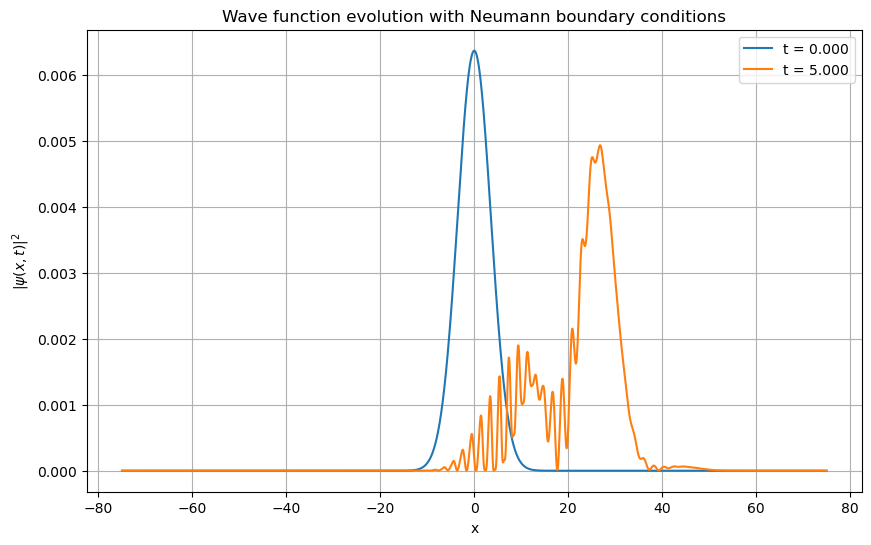

In [211]:
schrodinger_equation_solution(
    L              = 150.0,
    nx             = 2000,
    x0             = 0.0, 
    sigma          = 5.0,
    k0             = 0.0,
    T              = 5.0,
    dt             = 0.001,
    hbar           = 1.0,
    m              = 1.0,
    bc             = "Neumann",
    potential_type = "Linear",
    V0             = 1.0,
    a              = 2.0,
    F              = 2.0,
    n_plots        = 2
)